In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported!")

Libraries imported!


In [8]:
def create_sample_data():
    np.random.seed(42)
    n_samples = 100
    
    data = {
        'customer_id': range(1, n_samples + 1),
        'age': np.random.randint(18, 70, n_samples),
        'income': np.random.normal(50000, 15000, n_samples),
        'purchase_amount': np.random.exponential(100, n_samples),
        'signup_date': pd.date_range('2022-01-01', periods=n_samples, freq='D'),
        'product_category': np.random.choice(['Electronics', 'Clothing', 'Books', 'Home'], n_samples),
        'region': np.random.choice(['North', 'South', 'East', 'West'], n_samples)
    }
    
    df = pd.DataFrame(data)
    
    # Add some data issues
    df.loc[10:15, 'income'] = np.nan
    df.loc[20:25, 'product_category'] = None
    df.loc[30:35, 'age'] = -1
    df.loc[40:45, 'purchase_amount'] = 1000000
    
    # Add duplicates
    df = pd.concat([df, df.iloc[50:55]], ignore_index=True)
    
    return df

sample_data = create_sample_data()
print(f"Data shape: {sample_data.shape}")
sample_data.head()

Data shape: (105, 7)


,customer_id,age,income,purchase_amount,signup_date,product_category,region
0,1,56,21864.848417,119.001862,2022-01-01,Home,West
1,2,69,29498.267917,25.948345,2022-01-02,Books,North
2,3,46,59544.576625,19.231726,2022-01-03,Books,East
3,4,32,36399.189971,402.677994,2022-01-04,Clothing,North
4,5,60,57140.638811,72.698506,2022-01-05,Books,South


In [9]:
def clean_data(df):
    print("Cleaning data...")
    df_clean = df.copy()
    
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    
    # Fix negative values
    for col in numeric_cols:
        mask = df_clean[col] < 0
        if mask.any():
            df_clean.loc[mask, col] = np.nan
    
    # Fill missing numeric values
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            median_val = df_clean[col].median()
            mask = df_clean[col].isnull()
            df_clean.loc[mask, col] = median_val
    
    # Fill missing categorical values
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if df_clean[col].isnull().sum() > 0:
            mode_val = df_clean[col].mode()[0] if not df_clean[col].mode().empty else 'Unknown'
            mask = df_clean[col].isnull()
            df_clean.loc[mask, col] = mode_val
    
    # Remove duplicates
    initial_count = len(df_clean)
    df_clean = df_clean.drop_duplicates()
    print(f"Removed {initial_count - len(df_clean)} duplicates")
    
    # Create new features
    if 'signup_date' in df_clean.columns:
        df_clean['days_since_signup'] = (datetime.now() - df_clean['signup_date']).dt.days
    
    if 'age' in df_clean.columns:
        df_clean['age_group'] = pd.cut(df_clean['age'], 
                                      bins=[0, 25, 35, 45, 55, 100], 
                                      labels=['18-25', '26-35', '36-45', '46-55', '55+'])
    
    print(f"Final shape: {df_clean.shape}")
    return df_clean

cleaned_data = clean_data(sample_data)
cleaned_data.head()

Cleaning data...
Removed 5 duplicates
Final shape: (100, 9)


,customer_id,age,income,purchase_amount,signup_date,product_category,region,days_since_signup,age_group
0,1,56.0,21864.848417,119.001862,2022-01-01,Home,West,1358,55+
1,2,69.0,29498.267917,25.948345,2022-01-02,Books,North,1357,55+
2,3,46.0,59544.576625,19.231726,2022-01-03,Books,East,1356,46-55
3,4,32.0,36399.189971,402.677994,2022-01-04,Clothing,North,1355,26-35
4,5,60.0,57140.638811,72.698506,2022-01-05,Books,South,1354,55+


=== DATA ANALYSIS ===
Shape: (100, 9)

Basic statistics:
       customer_id         age        income  purchase_amount  \
count   100.000000  100.000000    100.000000       100.000000   
mean     50.500000   43.020000  50239.221899     60103.565754   
min       1.000000   19.000000  20901.331721         0.519835   
25%      25.750000   31.750000  39036.796465        33.244696   
50%      50.500000   41.000000  48737.523722        71.895881   
75%      75.250000   56.000000  59327.436633       187.840155   
max     100.000000   69.000000  94154.951247   1000000.000000   
std      29.011492   14.570608  14496.543034    238656.987815   

               signup_date  days_since_signup  
count                  100         100.000000  
mean   2022-02-19 12:00:00        1308.500000  
min    2022-01-01 00:00:00        1259.000000  
25%    2022-01-25 18:00:00        1283.750000  
50%    2022-02-19 12:00:00        1308.500000  
75%    2022-03-16 06:00:00        1333.250000  
max    2022-04-10 00:

/tmp/ipykernel_251/48679053.py:14: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



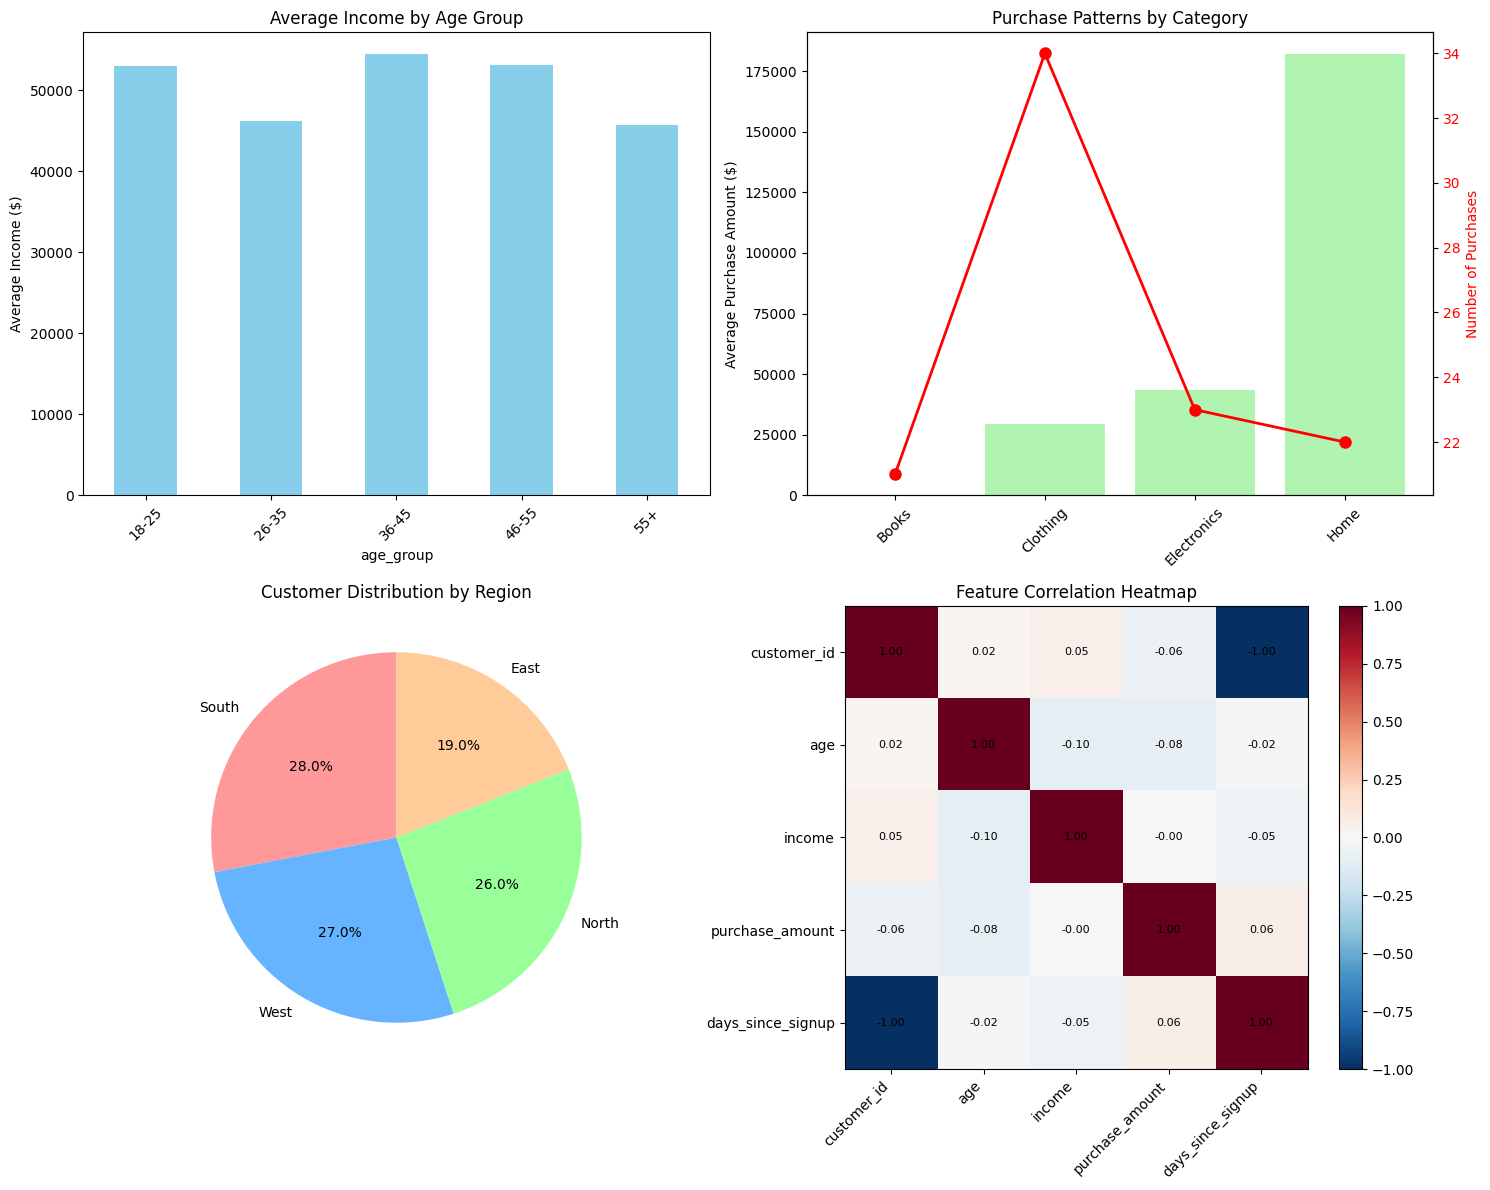


KEY BUSINESS METRICS:
Total Revenue: $6,010,356.58
Average Purchase: $60103.57
Largest Purchase: $1000000.00
Unique Customers: 100

Outlier detection:
Using IQR method for outliers:
  income: 1 outliers
  purchase_amount: 9 outliers


In [10]:
def analyze_data(df):
    print("=== DATA ANALYSIS ===")
    print(f"Shape: {df.shape}")
    
    # Basic stats
    print("\nBasic statistics:")
    print(df.describe())
    
    # Set up visualizations - more useful charts
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Income distribution by age group - more insightful
    if 'age_group' in df.columns and 'income' in df.columns:
        df.groupby('age_group')['income'].mean().plot(kind='bar', ax=axes[0, 0], color='skyblue')
        axes[0, 0].set_title('Average Income by Age Group')
        axes[0, 0].set_ylabel('Average Income ($)')
        axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Purchase patterns by product category - more business relevant
    if 'product_category' in df.columns and 'purchase_amount' in df.columns:
        category_stats = df.groupby('product_category')['purchase_amount'].agg(['mean', 'count'])
        x_pos = np.arange(len(category_stats))
        
        # Twin axis for average purchase amount and count
        ax1 = axes[0, 1]
        ax2 = ax1.twinx()
        
        bars = ax1.bar(x_pos, category_stats['mean'], alpha=0.7, color='lightgreen')
        ax1.set_ylabel('Average Purchase Amount ($)')
        ax1.set_title('Purchase Patterns by Category')
        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(category_stats.index, rotation=45)
        
        ax2.plot(x_pos, category_stats['count'], 'ro-', linewidth=2, markersize=8)
        ax2.set_ylabel('Number of Purchases', color='red')
        ax2.tick_params(axis='y', labelcolor='red')
    
    # 3. Regional distribution of customers - useful for marketing
    if 'region' in df.columns:
        region_counts = df['region'].value_counts()
        colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
        axes[1, 0].pie(region_counts.values, labels=region_counts.index, autopct='%1.1f%%',
                      colors=colors[:len(region_counts)], startangle=90)
        axes[1, 0].set_title('Customer Distribution by Region')
    
    # 4. Correlation heatmap - always useful
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        correlation_matrix = df[numeric_cols].corr()
        im = axes[1, 1].imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)
        axes[1, 1].set_title('Feature Correlation Heatmap')
        axes[1, 1].set_xticks(range(len(numeric_cols)))
        axes[1, 1].set_yticks(range(len(numeric_cols)))
        axes[1, 1].set_xticklabels(numeric_cols, rotation=45, ha='right')
        axes[1, 1].set_yticklabels(numeric_cols)
        
        # Add correlation values
        for i in range(len(numeric_cols)):
            for j in range(len(numeric_cols)):
                text = axes[1, 1].text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                                      ha="center", va="center", color="black", fontsize=8)
        
        plt.colorbar(im, ax=axes[1, 1])
    
    plt.tight_layout()
    plt.show()
    
    # Additional useful metrics
    print("\nKEY BUSINESS METRICS:")
    
    if 'purchase_amount' in df.columns:
        print(f"Total Revenue: ${df['purchase_amount'].sum():,.2f}")
        print(f"Average Purchase: ${df['purchase_amount'].mean():.2f}")
        print(f"Largest Purchase: ${df['purchase_amount'].max():.2f}")
    
    if 'customer_id' in df.columns:
        print(f"Unique Customers: {df['customer_id'].nunique()}")
    
    # Outlier detection
    print("\nOutlier detection:")
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    try:
        from scipy import stats
        print("Potential outliers (Z-score > 3):")
        for col in numeric_cols:
            z_scores = np.abs(stats.zscore(df[col]))
            outliers = len(np.where(z_scores > 3)[0])
            if outliers > 0:
                print(f"  {col}: {outliers} outliers")
                
    except ImportError:
        print("Using IQR method for outliers:")
        for col in numeric_cols:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            outliers = len(df[(df[col] < lower_bound) | (df[col] > upper_bound)])
            if outliers > 0:
                print(f"  {col}: {outliers} outliers")

analyze_data(cleaned_data)

Creating interactive business dashboards...


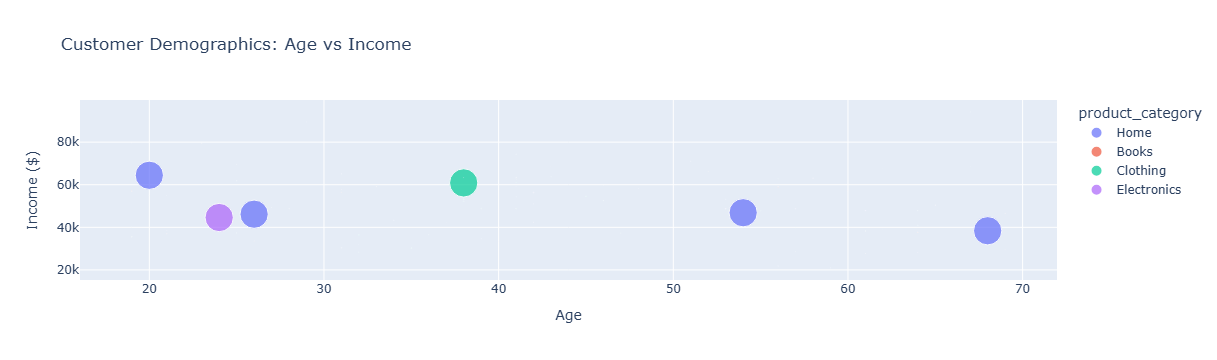

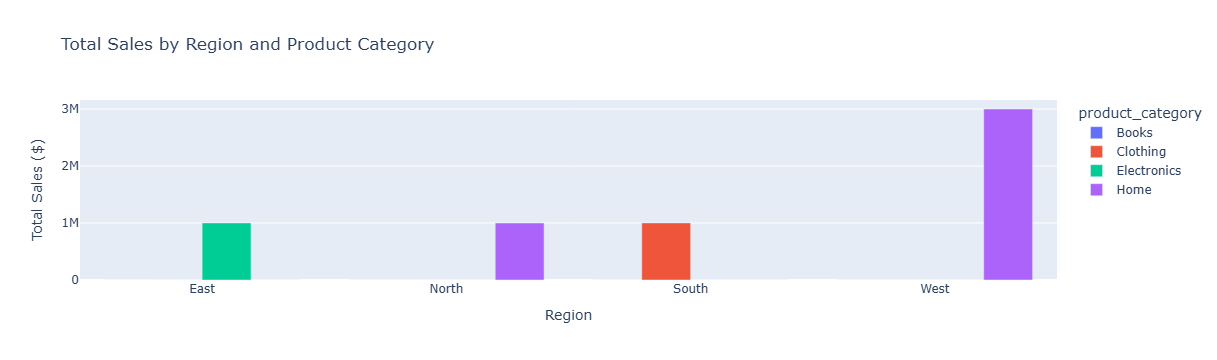

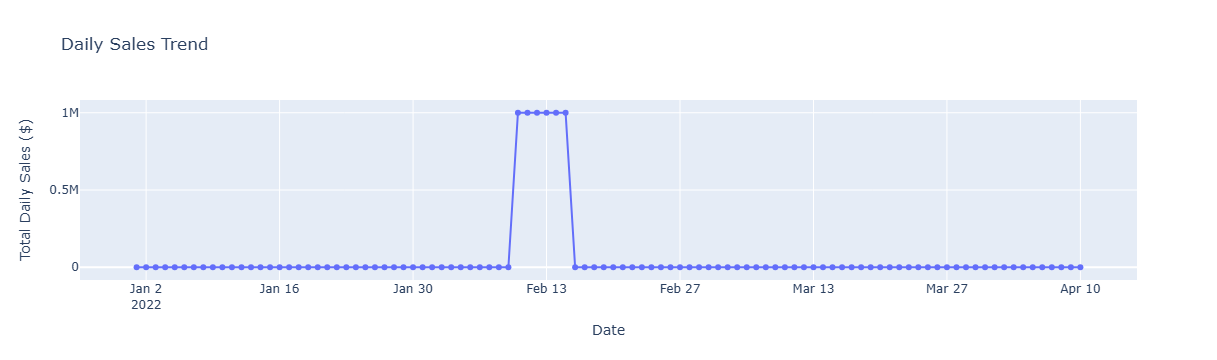

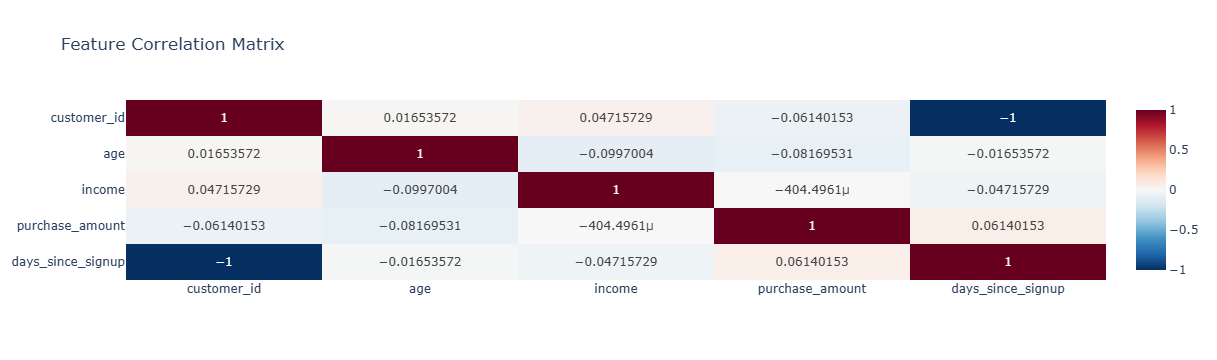

In [11]:
# Interactive visualizations with useful business insights
try:
    import plotly.express as px
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    print("Creating interactive business dashboards...")
    
    # 1. Customer demographics dashboard
    if 'age' in cleaned_data.columns and 'income' in cleaned_data.columns:
        fig = px.scatter(cleaned_data, x='age', y='income', 
                        color='product_category' if 'product_category' in cleaned_data.columns else None,
                        size='purchase_amount' if 'purchase_amount' in cleaned_data.columns else None,
                        title='Customer Demographics: Age vs Income',
                        hover_data=['region'] if 'region' in cleaned_data.columns else None)
        fig.update_layout(xaxis_title="Age", yaxis_title="Income ($)")
        fig.show()
    
    # 2. Sales performance by region and category
    if all(col in cleaned_data.columns for col in ['region', 'product_category', 'purchase_amount']):
        sales_summary = cleaned_data.groupby(['region', 'product_category'])['purchase_amount'].sum().reset_index()
        fig = px.bar(sales_summary, x='region', y='purchase_amount', color='product_category',
                    title='Total Sales by Region and Product Category',
                    barmode='group')
        fig.update_layout(xaxis_title="Region", yaxis_title="Total Sales ($)")
        fig.show()
    
    # 3. Time-based analysis if date available
    if 'signup_date' in cleaned_data.columns and 'purchase_amount' in cleaned_data.columns:
        time_series = cleaned_data.groupby('signup_date')['purchase_amount'].sum().reset_index()
        fig = px.line(time_series, x='signup_date', y='purchase_amount',
                     title='Daily Sales Trend', markers=True)
        fig.update_layout(xaxis_title="Date", yaxis_title="Total Daily Sales ($)")
        fig.show()
    
    # 4. Interactive correlation matrix
    numeric_cols = cleaned_data.select_dtypes(include=[np.number]).columns
    if len(numeric_cols) > 1:
        correlation_matrix = cleaned_data[numeric_cols].corr()
        fig = px.imshow(correlation_matrix, text_auto=True, aspect="auto",
                       color_continuous_scale='RdBu_r', zmin=-1, zmax=1,
                       title='Feature Correlation Matrix')
        fig.show()
        
except ImportError:
    print("Plotly not available - creating enhanced matplotlib visualizations")
    
    # Enhanced matplotlib versions
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Age vs Income scatter
    if 'age' in cleaned_data.columns and 'income' in cleaned_data.columns:
        scatter = axes[0, 0].scatter(cleaned_data['age'], cleaned_data['income'], 
                                   c=cleaned_data['purchase_amount'] if 'purchase_amount' in cleaned_data.columns else 'blue',
                                   alpha=0.6, cmap='viridis')
        axes[0, 0].set_xlabel('Age')
        axes[0, 0].set_ylabel('Income ($)')
        axes[0, 0].set_title('Age vs Income')
        if 'purchase_amount' in cleaned_data.columns:
            plt.colorbar(scatter, ax=axes[0, 0], label='Purchase Amount')
    
    # 2. Sales by region and category
    if all(col in cleaned_data.columns for col in ['region', 'product_category', 'purchase_amount']):
        sales_data = cleaned_data.groupby(['region', 'product_category'])['purchase_amount'].sum().unstack()
        sales_data.plot(kind='bar', ax=axes[0, 1])
        axes[0, 1].set_title('Sales by Region and Category')
        axes[0, 1].set_ylabel('Total Sales ($)')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].legend(title='Product Category')
    
    # 3. Customer distribution by age group
    if 'age_group' in cleaned_data.columns:
        age_dist = cleaned_data['age_group'].value_counts().sort_index()
        axes[1, 0].bar(age_dist.index.astype(str), age_dist.values, color='lightblue')
        axes[1, 0].set_title('Customer Distribution by Age Group')
        axes[1, 0].set_ylabel('Number of Customers')
        axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 4. Average purchase by category
    if 'product_category' in cleaned_data.columns and 'purchase_amount' in cleaned_data.columns:
        avg_purchase = cleaned_data.groupby('product_category')['purchase_amount'].mean().sort_values(ascending=False)
        axes

In [12]:
# SQL database example
import sqlite3

def demo_sql():
    conn = sqlite3.connect(':memory:')
    
    # Create tables
    cursor = conn.cursor()
    cursor.execute('''
    CREATE TABLE customers (
        customer_id INTEGER PRIMARY KEY,
        age INTEGER,
        income REAL,
        region TEXT
    )
    ''')
    
    # Insert data
    customer_data = cleaned_data[['customer_id', 'age', 'income', 'region']].copy()
    customer_data.to_sql('customers', conn, if_exists='append', index=False)
    
    # Run queries
    query = "SELECT region, AVG(income) as avg_income FROM customers GROUP BY region"
    result = pd.read_sql_query(query, conn)
    print("Average income by region:")
    print(result)
    
    conn.close()

demo_sql()

Average income by region:
  region    avg_income
0   East  51748.191804
1  North  45322.434947
2  South  53100.976335
3   West  50944.292580


=== REPORT ===
- Records: 100
- Features: 9
- customer_id: Mean = $50.50
- age: Mean = $43.02
- income: Mean = $50239.22
- purchase_amount: Mean = $60103.57
- days_since_signup: Mean = $1308.50
Chart saved: report_chart.png


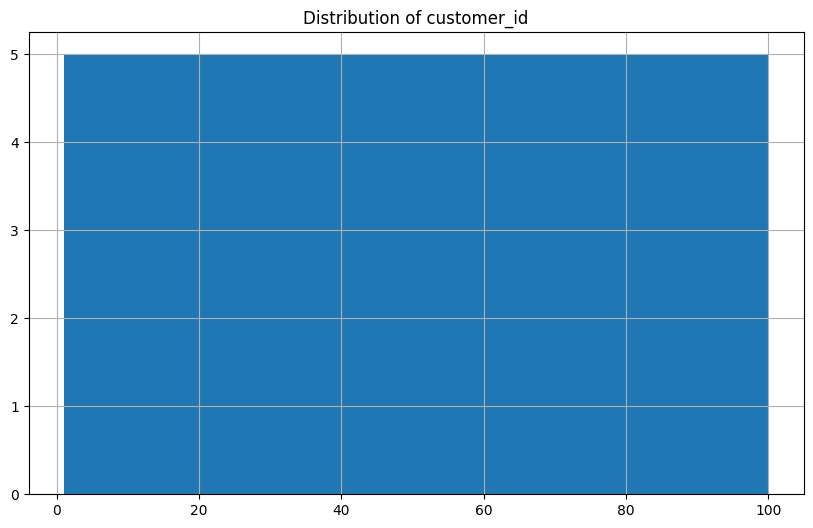

In [13]:
# Automated report
def create_report(df):
    report_date = datetime.now().strftime("%Y-%m-%d")
    
    insights = []
    insights.append(f"Records: {len(df)}")
    insights.append(f"Features: {len(df.columns)}")
    
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        insights.append(f"{col}: Mean = ${df[col].mean():.2f}")
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    if len(numeric_cols) > 0:
        df[numeric_cols[0]].hist(bins=20)
        plt.title(f'Distribution of {numeric_cols[0]}')
        plt.savefig('report_chart.png')
    
    print("=== REPORT ===")
    for insight in insights:
        print(f"- {insight}")
    
    print("Chart saved: report_chart.png")

create_report(cleaned_data)